# Day 08. Exercise 05
# Clustering

## 0. Imports

In [390]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap

from sklearn.model_selection import (
  train_test_split
)

from sklearn.linear_model import (
  LinearRegression
)

from sklearn.tree import (
  DecisionTreeRegressor,
  plot_tree
)

from sklearn.svm import (
  SVC
)

from sklearn.metrics import (
  accuracy_score,
  mean_squared_error,
  silhouette_score,
)

from sklearn.inspection import (
  DecisionBoundaryDisplay
)

from sklearn.preprocessing import (
  StandardScaler,
  OneHotEncoder
)

from sklearn.pipeline import make_pipeline

from sklearn.multiclass import OneVsRestClassifier

from sklearn.ensemble import (
  RandomForestRegressor
)

from sklearn.model_selection import (
  cross_val_score,
  KFold
)

from sklearn.cluster import (
  KMeans,
  AgglomerativeClustering,
  DBSCAN
)

import joblib

from typing import (
  Dict, Any, Tuple
)

from sklearn.base import (
  ClassifierMixin
)

from scipy.cluster.hierarchy import dendrogram, linkage

## 1. Preprocessing

1. Read the file [`regression.csv`](https://drive.google.com/file/d/1fzOPkuXoxLleOsvNVCT0m-LKxlid33ma/view?usp=sharing) to a dataframe.
2. Remove the `pageviews`, we will cluster the users only by the number of the commits and their average difference.

In [14]:
df = pd.read_csv('../../datasets/regression.csv').drop('pageviews', axis=1).set_index('uid')
df

,num_commits,AVG(diff)
uid,,
user_1,62,-64.400000
user_10,20,-74.800000
user_14,61,-159.000000
user_17,51,-61.600000
user_18,5,-5.666667
user_19,118,-98.750000
user_21,65,-95.500000
user_25,79,-92.600000
user_28,60,-86.400000


## 5. Function

Write a function that:
1. Takes as arguments: model class of clustering, its parameters, the name of the parameter for optimization, the range of the parameter values to try.
2. Tries different values from the given parameter range and calculates the `silhouette_score` for each value from the range.
3. Finds out the best value for the parameter in the range.
4. Returns two subplots:


- - the first shows how the `silhouette_score` changes depending on the value of the parameter,
- - the second visualizes the data on a `scatter plot` using the clustering model with the best value of the parameter.

In [376]:
def optimize_clustring(
    model_class : ClassifierMixin,
    fixed_params : Dict[str, Any],
    variable_param : str,
    p_range, 
    X : pd.DataFrame,
    figsize : Tuple[int, int] = (15, 20),
):
    
    def gen_mosaic(p_range, ncols, name):
        nrows = int((p_range.stop - p_range.start)/ ncols)

        mosaic = []

        for k in range(p_range.start, p_range.stop, ncols):
            mosaic.append([f'{name} = {k + i}' for i in range(ncols)])

        mosaic.append([f'Silhouette Score vs {name}'] * 2)
        return mosaic

    sil_scores = []

    ncols = 2
    nrows = int((p_range.stop - p_range.start)/ ncols)

    fig = plt.figure(figsize=figsize, constrained_layout=True)
    axs = fig.subplot_mosaic(
        gen_mosaic(p_range, ncols, variable_param)
    )

    for k, ax in zip(p_range, list(axs.values())[:-1]):
        model = model_class(**{variable_param : k}, **fixed_params)
        model.fit(X)
        sil_scores.append(silhouette_score(df, model.labels_))
        sns.scatterplot(
            data=df, 
            x='num_commits', 
            y='AVG(diff)', 
            hue=model.labels_, 
            palette='Set1', 
            ax=ax,

        )
        ax.set_title(f'{variable_param}={k}')

    plt.plot(p_range, sil_scores, marker='o', markersize=10, color='red')
    axs[f'Silhouette Score vs {variable_param}'].set_title(f'Silhouette Score vs {variable_param}')
    plt.xlabel(variable_param)
    plt.ylabel('Silhouette Score')
    plt.grid()
    plt.show()

    best_param = p_range[np.argmax(sil_scores)]
    best_score = np.max(sil_scores)

    print(f'Best {variable_param} = {best_param}\nSilhouette_score = {best_score}')

## 2. KMeans

1. Check the documentation about how this algorithm works.
2. Use this algorithm to create clusters, use `random_state=21` and `n_clusters=3`.
3. Visualize the data on a `scatter plot`.
4. Try different values of `n_clusters` and see how your plot will change.
5. Calculate the `silhouette_score` (check the docs about the metric).

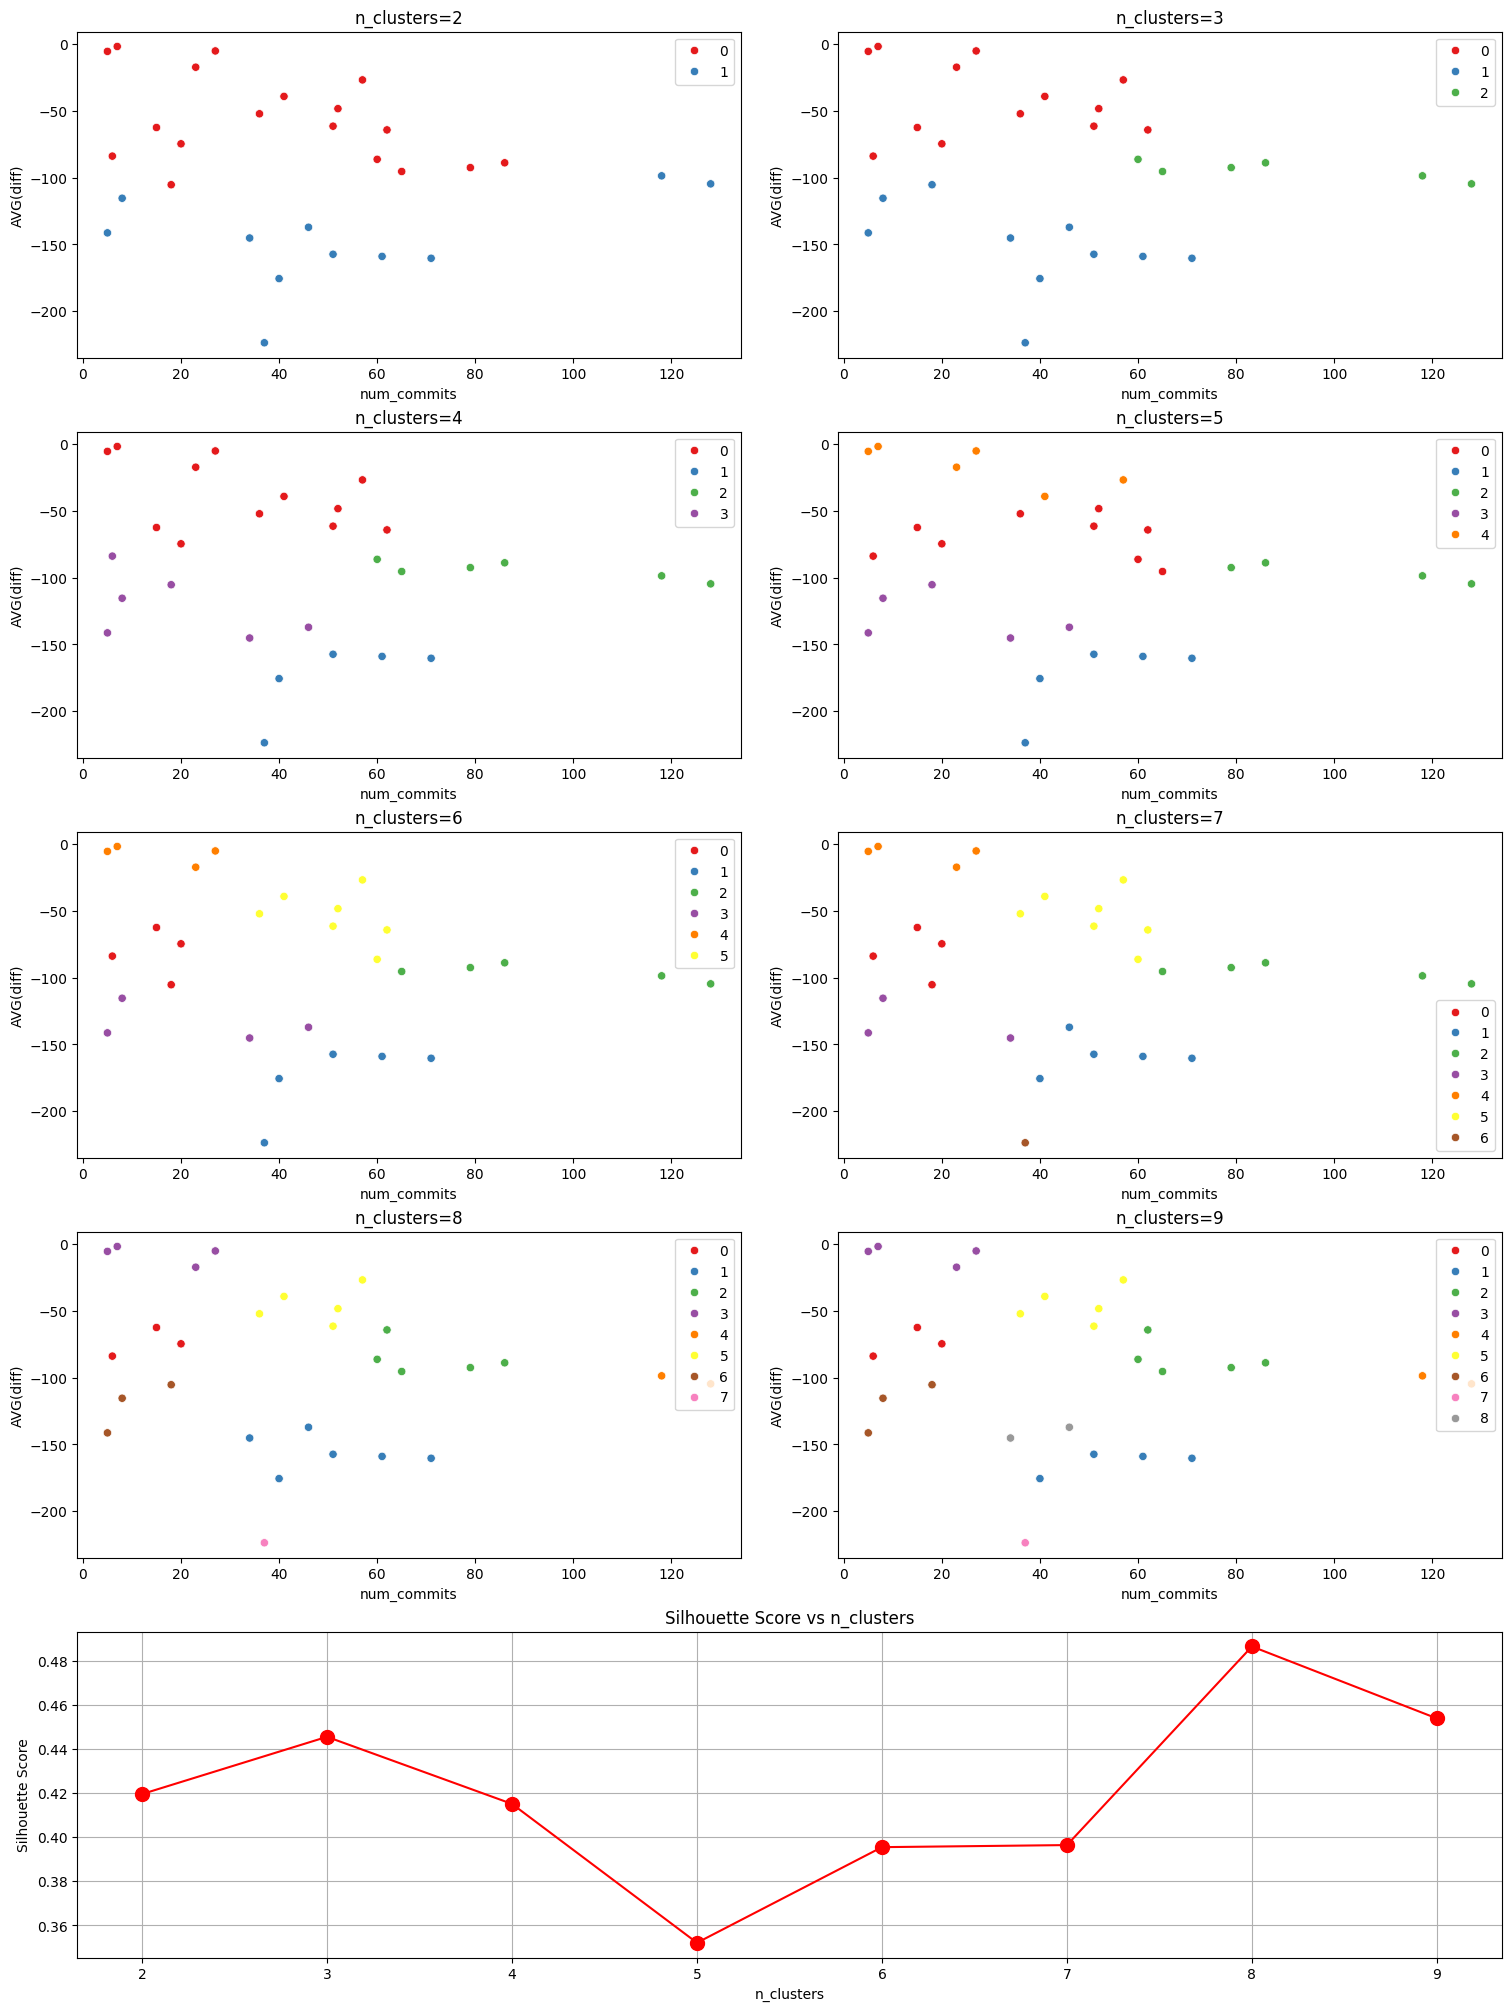

Best n_clusters = 8
Silhouette_score = 0.48638087320227846


In [377]:
optimize_clustring(
    model_class=KMeans,
    fixed_params={'random_state': 21},
    variable_param='n_clusters',
    p_range=range(2, 10),
    X=df
)

## 3. DBSCAN

1. Check the documentation about how this algorithm works.
2. Use this algorithm to create clusters with `eps=20` and `min_samples=2`.
3. Visualize the data on a `scatter plot`.
4. Try different values of `eps` and `min_samples` and see how your plot will change.
5. Calculate the `silhouette_score` (check the docs about the metric).

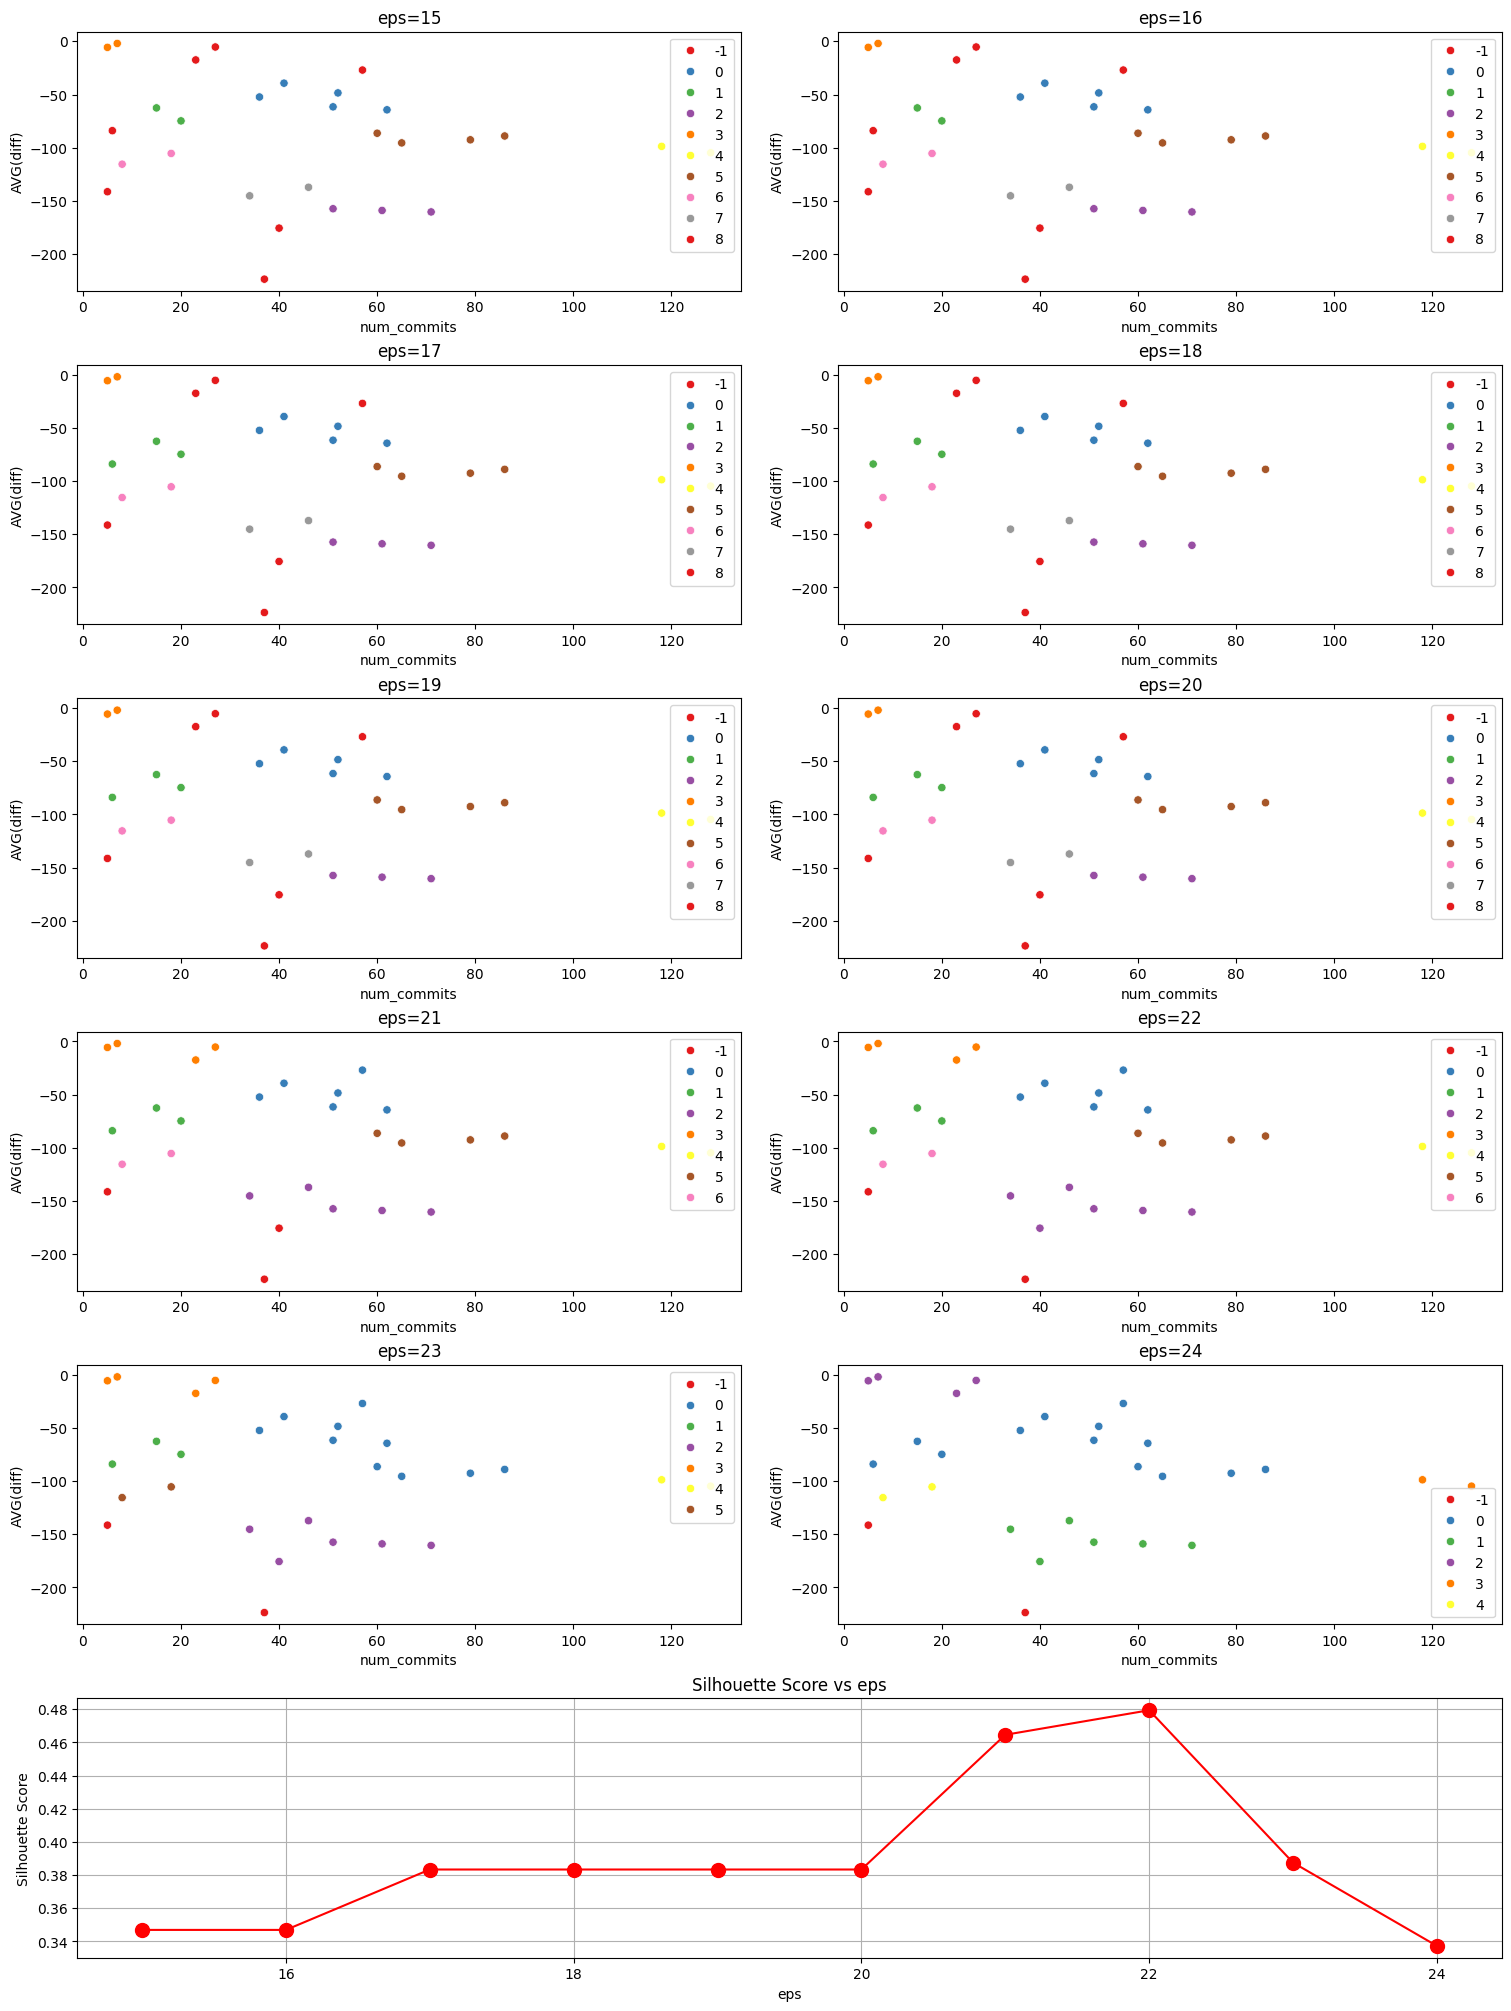

Best eps = 22
Silhouette_score = 0.4794129092034348


In [378]:
optimize_clustring(
    model_class=DBSCAN,
    fixed_params={'min_samples' : 2},
    variable_param='eps',
    p_range=range(15, 25),
    X=df
)

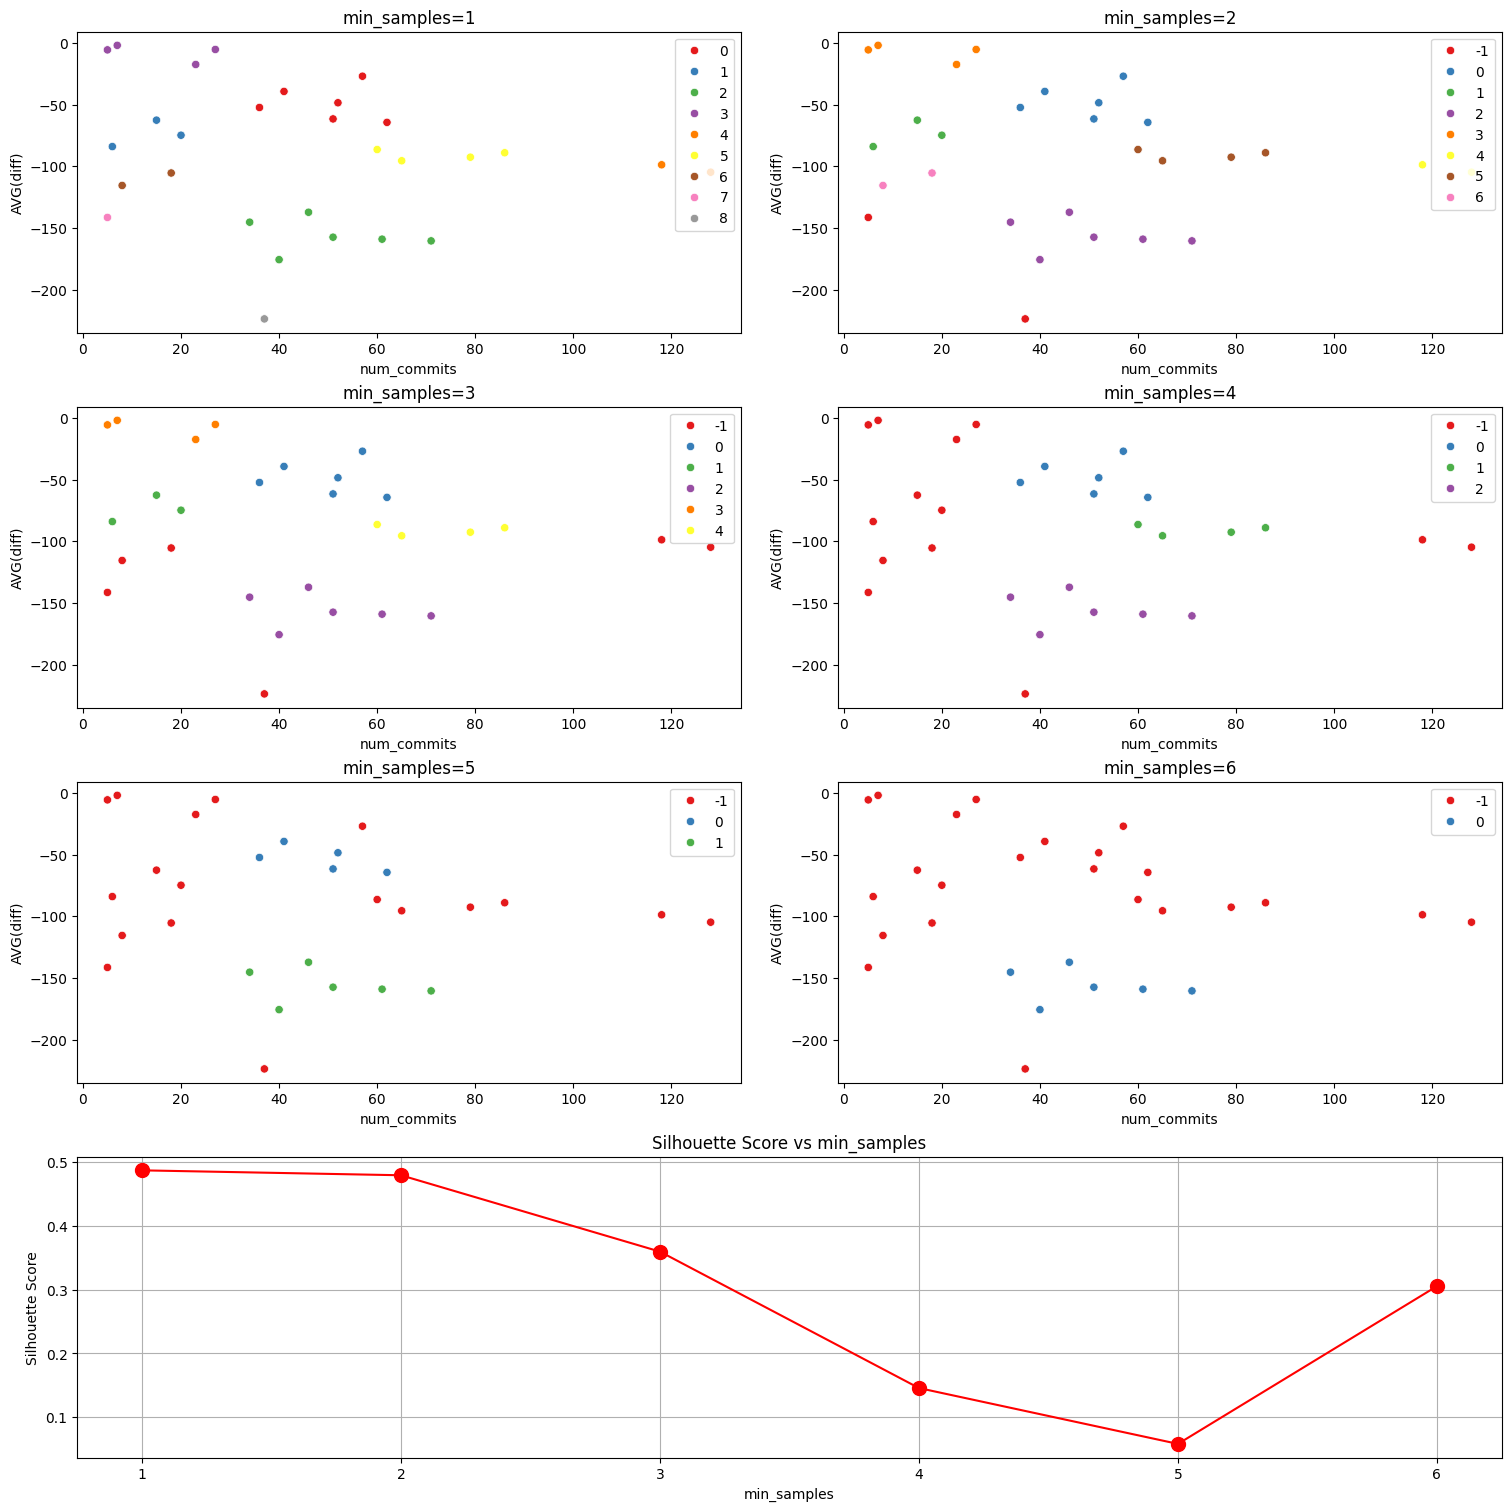

Best min_samples = 1
Silhouette_score = 0.48713041554757475


In [385]:
optimize_clustring(
    model_class=DBSCAN,
    fixed_params={'eps' : 22},
    variable_param='min_samples',
    p_range=range(1, 7),
    X=df,
    figsize=(15, 15)
)

## 4. Hierarchical (AgglomerativeClustering)

1. Use this algorithm to create clusters with `n_clusters=5`.
2. Visualize the data on a `scatter plot`.
3. Try different values of `n_clusters` and see how your plot will change.
4. Calculate the `silhouette_score`.
5. Visualize the `dendrogram`.

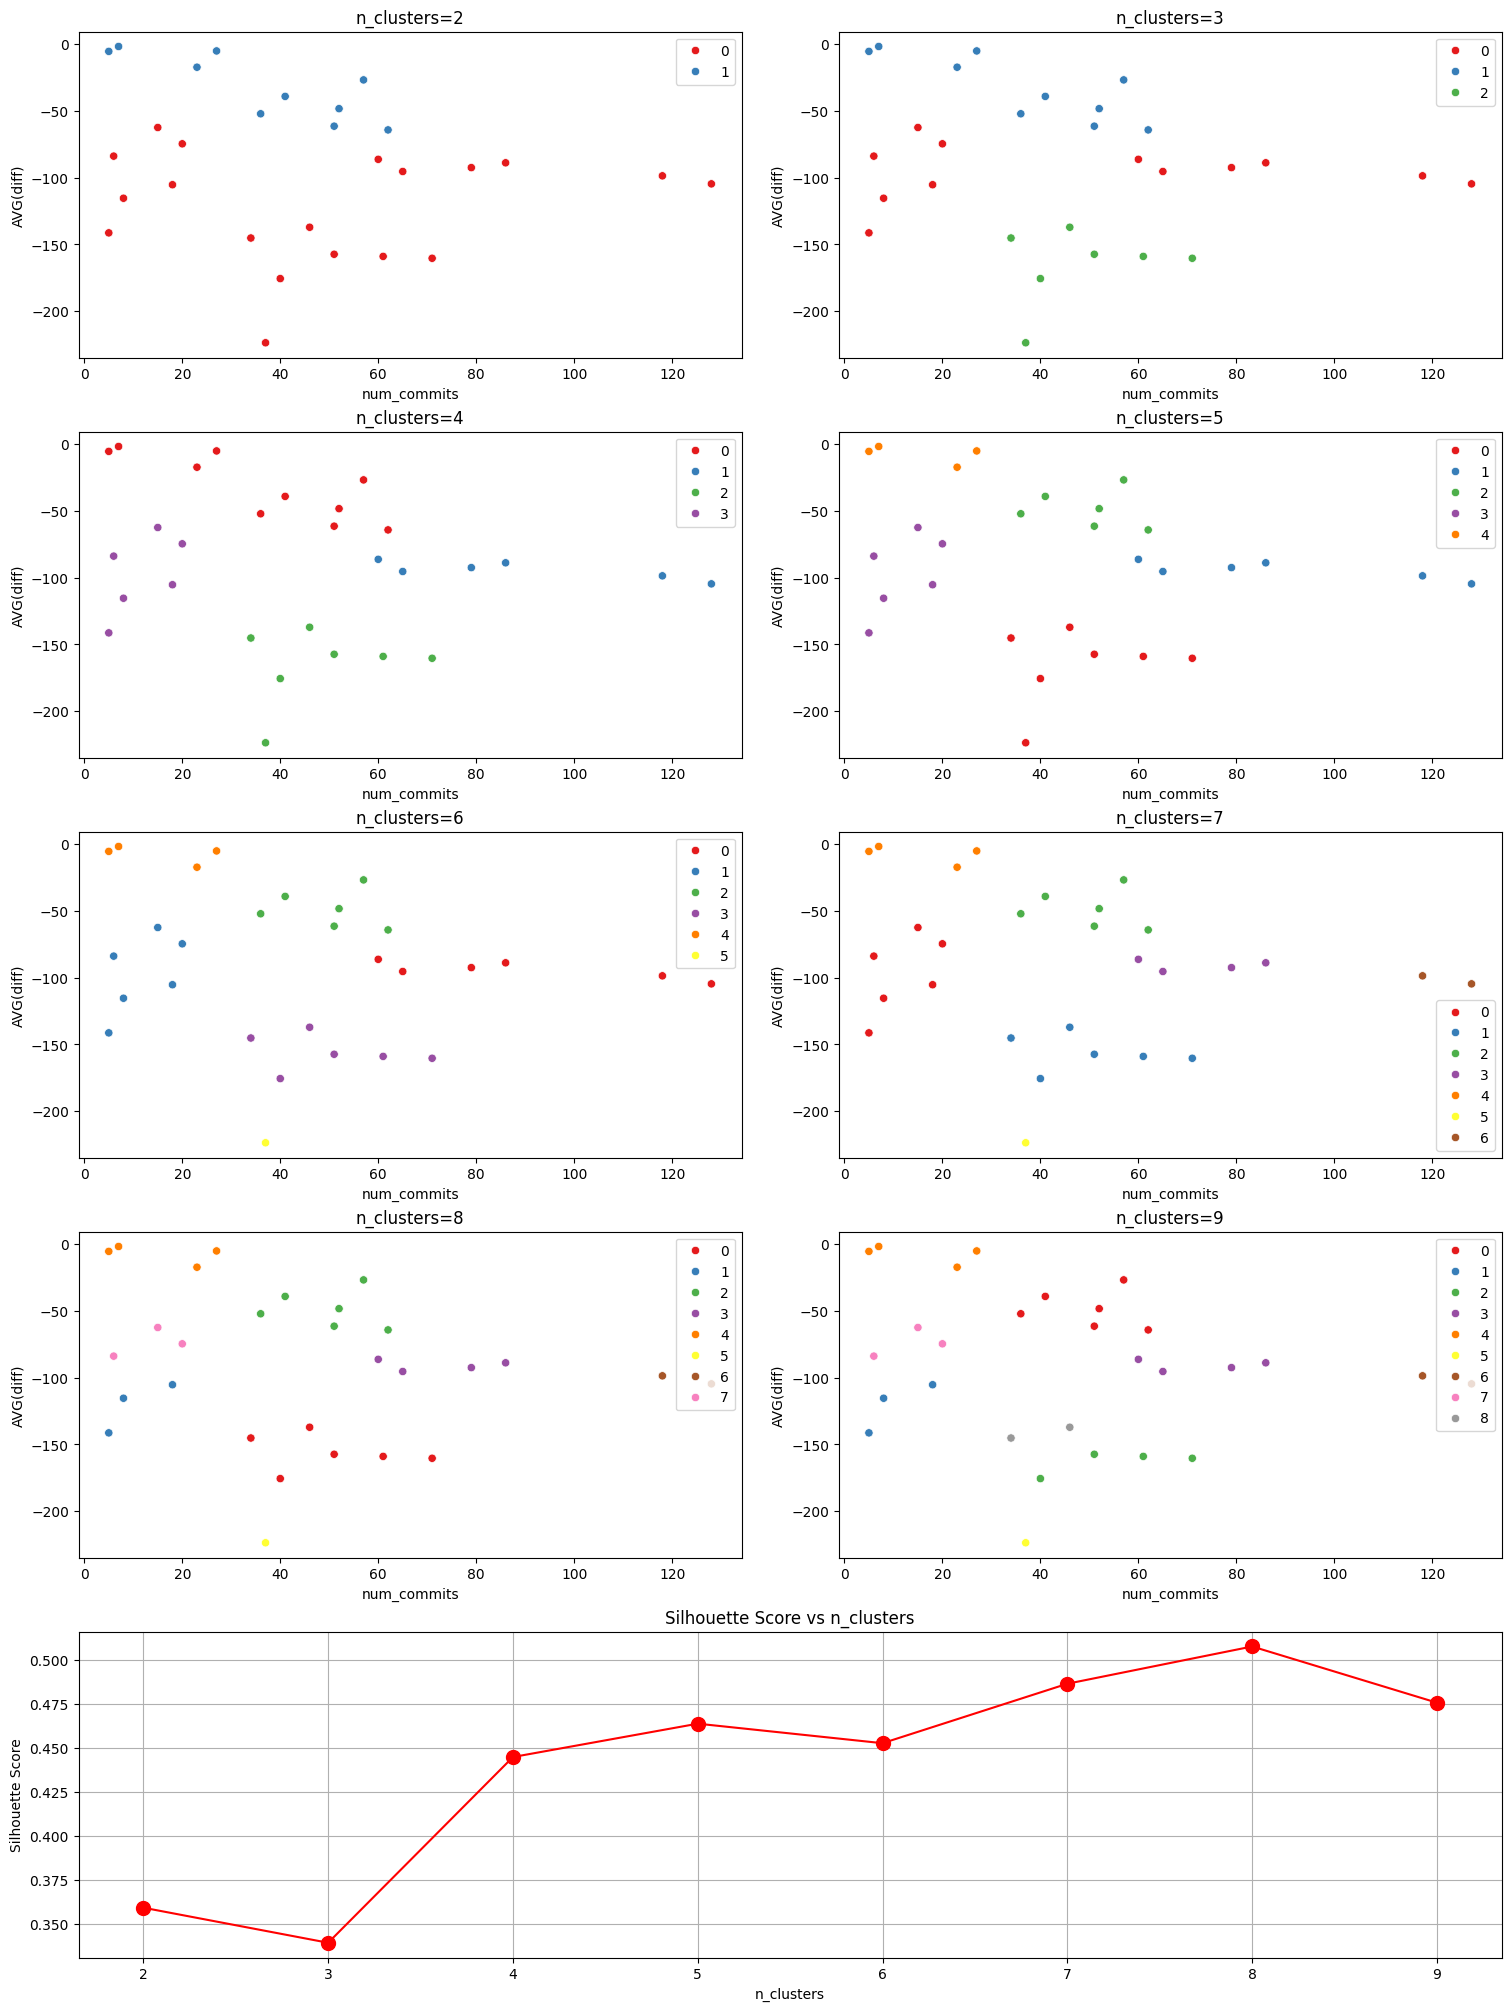

Best n_clusters = 8
Silhouette_score = 0.50779855565622


In [386]:
optimize_clustring(
  model_class=AgglomerativeClustering,
  fixed_params={},
  variable_param='n_clusters',
  p_range=range(2, 10),
  X=df
)

In [391]:
cluster = AgglomerativeClustering(
    n_clusters=5
).fit(df)

silhouette_score(df, cluster.labels_)

np.float64(0.4641623710088179)

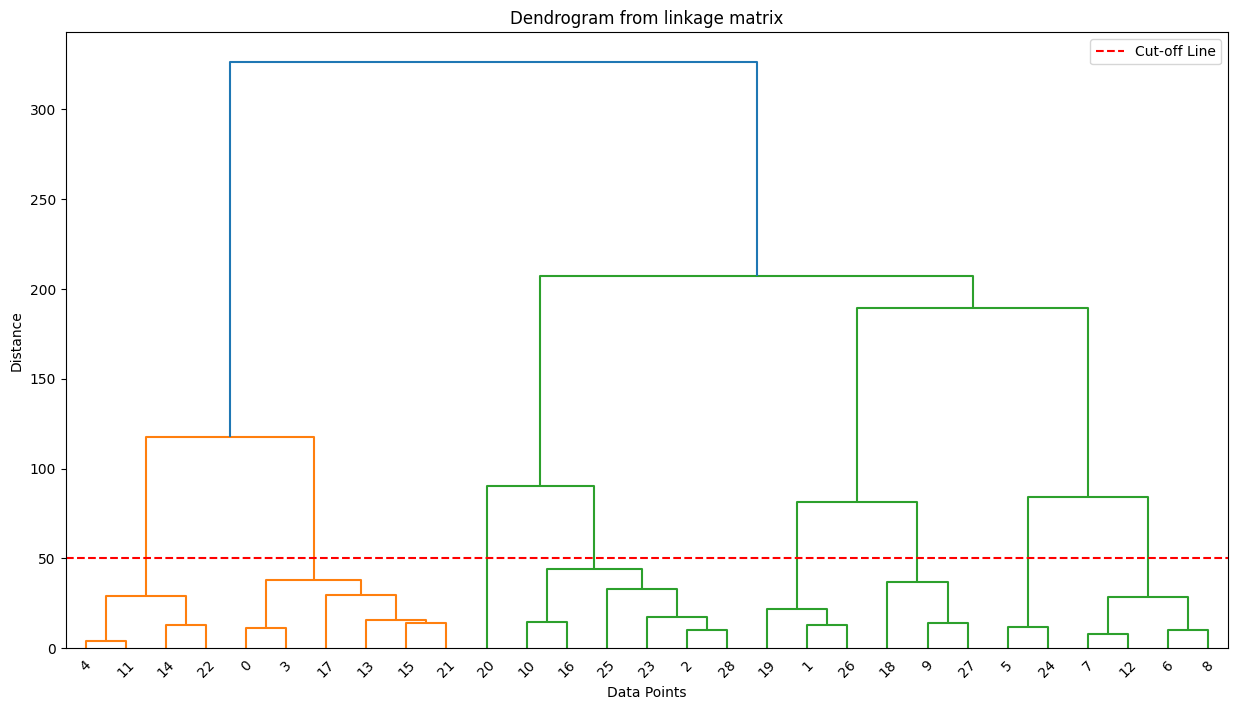

In [401]:
Z = linkage(df, method='ward')
fig = plt.figure(figsize=(15, 8))
dendrogram(Z)
plt.title("Dendrogram from linkage matrix")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.axhline(y=50, color='r', linestyle='--', label="Cut-off Line")
plt.legend()
plt.show()